In [1]:
from functions.data_by_country import data_by_country
from utils.data_loader import load_data_parquet
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import seaborn as sns
from functions.adf_check import adf_check
from functions.best_model_arma import best_model_arma
from functions.acf_pacf import acf_pacf
from functions.kmeans import KMeans
from functions.isolation_forest import IsolationForest
from functions.one_class_svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from functions.arma import ARMA

In [2]:
df = load_data_parquet()
df = data_by_country(df)
df = df.dropna()
#df = df.set_index("dt")

c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[["Country", "AverageTemperature", "dt", "Country_ISO"]


In [3]:
df

,Country,Country_ISO,dt,AverageTemperature
1070,Afghanistan,AFG,1833-01-01,1.145000
1071,Afghanistan,AFG,1833-02-01,2.168400
1072,Afghanistan,AFG,1833-03-01,6.516200
1073,Afghanistan,AFG,1833-04-01,12.832200
1074,Afghanistan,AFG,1833-05-01,18.544800
...,...,...,...,...
81885153,Zimbabwe,ZWE,2013-04-01,19.770143
81885154,Zimbabwe,ZWE,2013-05-01,17.851714
81885155,Zimbabwe,ZWE,2013-06-01,16.527143
81885156,Zimbabwe,ZWE,2013-07-01,15.858857


In [44]:
# # First, group by both 'Country' and year and calculate the mean temperature
# df_country_year = df.groupby(['Country',"Country_ISO", df.dt.dt.year])['AverageTemperature'].mean().reset_index()

# # Rename the columns for clarity
# df_country_year.columns = ['Country',"Country_ISO", 'dt', 'AverageTemperature']

# # Now, df_country_year contains the average temperature per year per country
# df_country_year = df_country_year.dropna()

# # df_country_year = df_country_year.set_index("Year")

# df_country_year

In [5]:
df2 = load_data_parquet()
df2 = data_by_country(df2)
df2 = df2.dropna()
df2 = df2.pivot(index="dt", columns="Country",
              values='AverageTemperature').dropna()

trend_components = {}
slopes = {}
for country in df2.columns:
    result = seasonal_decompose(df2[country], model='additive', period=12)
    trend_components[country] = result.trend.dropna()
all_trends = pd.concat(trend_components, axis=1)

scaler = MinMaxScaler()
all_normalized_trends = pd.DataFrame(scaler.fit_transform(
    all_trends), index=all_trends.index, columns=all_trends.columns)
# Calculate the slope based on the normalized trend
for country in all_normalized_trends.columns:
    x_data = range(len(all_normalized_trends[country]))
    y_data = all_normalized_trends[country].dropna().values

    slope, _ = np.polyfit(x_data, y_data, 1)
    slopes[country] = slope

slopes_df = pd.DataFrame(list(slopes.items()), columns=['Country', 'Slope'])
slopes_df = slopes_df.sort_values(by='Slope', ascending=False)

slopes_df

c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[["Country", "AverageTemperature", "dt", "Country_ISO"]


,Country,Slope
67,Indonesia,0.000422
117,Réunion,0.000409
91,Mauritius,0.000395
112,Philippines,0.000392
88,Malaysia,0.000391
...,...,...
39,Denmark,0.000145
47,Estonia,0.000145
136,Sweden,0.000143
65,Iceland,0.000136


# Clustering

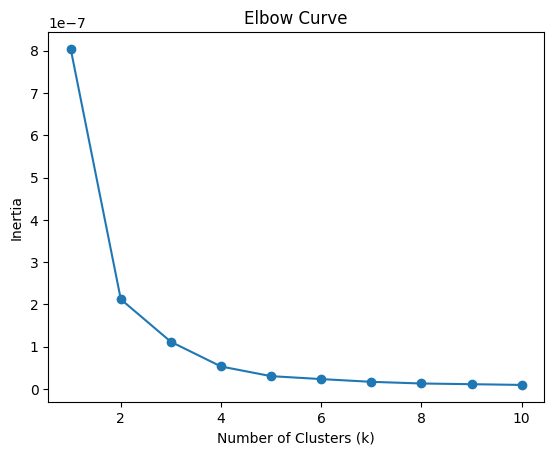

In [6]:
slopes_arr = np.array(slopes_df['Slope']).reshape(-1, 1)

inertia = []

for i in range(1, 11):
    # Initialize and fit the KMeans model
    kmeans = KMeans(k=i)
    kmeans.fit(slopes_arr)
    
    # Append inertia to the list
    inertia.append(kmeans.inertia_)
    
    
# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [7]:
    
#Applying K-means clustering
n_clusters = 3 
kmeans = KMeans(k=n_clusters)
kmeans.fit(slopes_arr)

#Assigning cluster labels to the DataFrame
slopes_df['Cluster'] = kmeans.labels_
slopes_df = slopes_df.sort_values(by='Slope', ascending=False)
slopes_df = slopes_df.merge(df[['Country', 'Country_ISO']].drop_duplicates(), on='Country', how='left')
slopes_df

,Country,Slope,Cluster,Country_ISO
0,Indonesia,0.000422,2,IDN
1,Réunion,0.000409,2,REU
2,Mauritius,0.000395,2,MUS
3,Philippines,0.000392,2,PHL
4,Malaysia,0.000391,2,MYS
...,...,...,...,...
154,Denmark,0.000145,1,DNK
155,Estonia,0.000145,1,EST
156,Sweden,0.000143,1,SWE
157,Iceland,0.000136,1,ISL


C:\Users\gaute\AppData\Local\Temp\ipykernel_1440\4138414442.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Number of Countries', data=cluster_counts_df, palette='viridis')


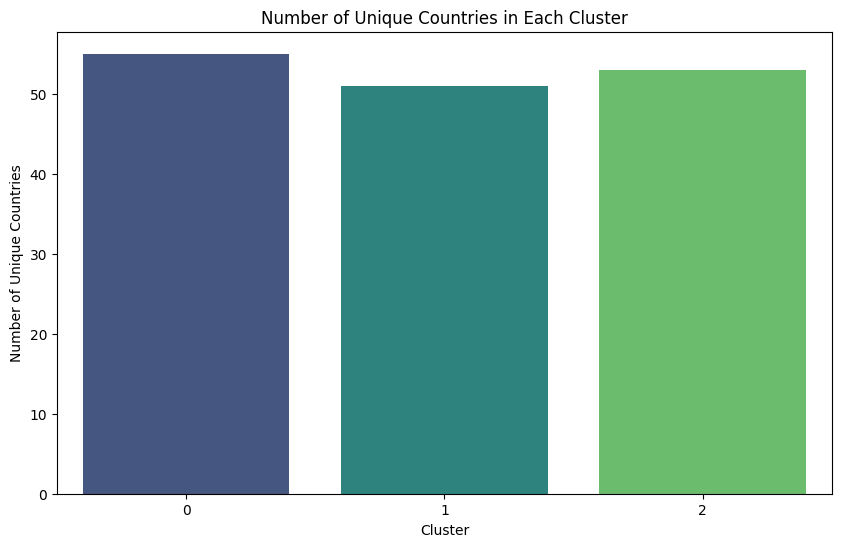

In [8]:
# Create a DataFrame to store unique countries in each cluster
# Count the number of unique countries in each cluster
cluster_counts = slopes_df['Cluster'].value_counts()

# Create a DataFrame to store cluster counts
cluster_counts_df = pd.DataFrame({'Cluster': cluster_counts.index, 'Number of Countries': cluster_counts.values})

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Number of Countries', data=cluster_counts_df, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of Unique Countries')
plt.title('Number of Unique Countries in Each Cluster')
plt.show()

In [9]:


# Create a Choropleth map with clusters
fig = px.choropleth(
    slopes_df,
    locations='Country_ISO',
    color='Cluster',
    hover_name='Country',
    color_continuous_scale=px.colors.sequential.Viridis,
    title='Cluster Visualization on Choropleth Map'
)

fig.show()

# ARIMA

In [10]:
# Merge the two DataFrames based on the 'Country' column
merged_df = pd.merge(df, slopes_df[['Country','Cluster']], on=['Country'], how='left')

# Convert the 'Date' column to the index
merged_df.set_index('dt', inplace=True)



In [46]:
# # Merge the two DataFrames based on the 'Country' column
# merged_df2 = pd.merge(df_country_year, slopes_df[['Country','Cluster']], on=['Country'], how='left')

# # Convert the 'Date' column to the index
# merged_df2.set_index('dt', inplace=True)
# merged_df2

In [31]:

# First, group by both 'Country' and year and calculate the mean temperature
df_clusters = merged_df.groupby(['Cluster', merged_df.index])['AverageTemperature'].mean().reset_index()

# Rename the columns for clarity
df_clusters.columns = ['Cluster', 'dt', 'AverageTemperature']


# Now, df_country_year contains the average temperature per year per country
df_clusters = df_clusters.dropna()

df_clusters = df_clusters.set_index("dt")

#df_clusters = df_clusters.loc[(df_clusters.index >= "1800-01-01") & (df_clusters.index <= "2013-08-01")]
df_clusters

,Cluster,AverageTemperature
dt,,
1743-11-01,0,3.352092
1744-04-01,0,9.360264
1744-05-01,0,12.601116
1744-06-01,0,17.321299
1744-07-01,0,18.833427
...,...,...
2013-05-01,2,24.614052
2013-06-01,2,24.093289
2013-07-01,2,23.679839


In [45]:
# # First, group by both 'Country' and year and calculate the mean temperature
# df_clusters2 = merged_df2.groupby(['Cluster', merged_df2.index])['AverageTemperature'].mean().reset_index()

# # Rename the columns for clarity
# df_clusters2.columns = ['Cluster', 'dt', 'AverageTemperature']


# # Now, df_country_year contains the average temperature per year per country
# df_clusters2 = df_clusters2.dropna()

# df_clusters2 = df_clusters2.set_index("dt")

# df_clusters2 = df_clusters2.loc[(df_clusters2.index >= 1833) & (df_clusters2.index <= 2013)]
# df_clusters2

In [32]:
df_clusters = df_clusters.groupby("Cluster",observed=False)

# # rows = df_clusters.size()
# # least_rows = rows.min()


In [15]:
#df_clusters2 = df_clusters2.groupby("Cluster",observed=False)

In [33]:
result_df = pd.DataFrame()

# Initialize counters for stationary and non-stationary countries
stationary_count_first_round = 0
non_stationary_count_first_round = 0

stationary_count_second_round = 0
non_stationary_count_second_round = 0
# Define the range of p and q values to search
max_p = 10
max_q = 10

for i, j in df_clusters:
    # Extract the last rows with similar shape
    data = j.copy()
    #data = data.tail(least_rows)
    
    # Perform seasonal decomposition
    result = seasonal_decompose(data.AverageTemperature, model='additive', period=12)
    
    # Get the trend component and drop NaN values
    trend_components = result.trend.dropna()
    
    # Ensure the indices match
    trend_components.index = data.index[-len(trend_components):]
    
    # Add the 'Trend' column to the data DataFrame
    data["Trend"] = trend_components
    
    # Concatenate the current data DataFrame with the result DataFrame
    data = data.dropna()
    data_to_use = data["Trend"]
    data_to_use = pd.DataFrame(data_to_use)
    data_to_use.rename(columns={"Trend": "AverageTemperature"}, inplace=True)
    
    # Check for stationarity using ADF test
    adf = adf_check(data_to_use["AverageTemperature"], "AIC")
    
    
    # Check if p-value is less than 0.5
    if adf[1] <= 0.05:
        stationary_count_first_round += 1
        # Time series is stationary
        # Find the best (p, q) orders using the best_model_arma function
        best_mse, best_rmse = best_model_arma(data_to_use, max_p, max_q)
        # Run ARMA with the best (p, q) orders
        results = ARMA(data_to_use, best_rmse[0], best_rmse[1])
        
        if results is not None:
            a = results[0]
            a["Cluster"] = j["Cluster"]
            # a["Country_ISO"] = j["Country_ISO"]
            result_df = pd.concat([result_df, a])
    else:
        non_stationary_count_first_round += 1
        #Time series is non-stationary
        # Perform necessary steps to make it stationary and then run ARMA
        original_data = data_to_use.copy()
        data_to_use["AverageTemperature"] = data_to_use["AverageTemperature"].diff().diff(12).dropna()
        
        data_to_use = data_to_use.dropna()
        
        adf = adf_check(data_to_use["AverageTemperature"], "AIC")
    
        # Check if p-value is less than 0.5
        if adf[1] <= 0.05:
            stationary_count_second_round += 1
            # Time series is stationary
            # Find the best (p, q) orders using the best_model_arma function
            best_mse, best_rmse = best_model_arma(data_to_use, max_p, max_q)
            # Run ARMA with the best (p, q) orders
            results = ARMA(data_to_use, best_rmse[0], best_rmse[1])
        
            if results is not None:
                a = results[0]
                #print(a)
                a.AverageTemperature += a.shift(1).AverageTemperature
                a.AverageTemperature += a.diff().shift(12).AverageTemperature
                a.Predicted_Values += a.shift(1).Predicted_Values 
                a.Predicted_Values += a.diff().shift(12).Predicted_Values
                a["Cluster"] = j["Cluster"]
                # a["Country_ISO"] = j["Country_ISO"]
                result_df = pd.concat([result_df, a])
        else:
            non_stationary_count_second_round += 1

The best model according to MSE is p = 1, q = 10, with MSE = 0.00039200530598660016 !
The best model according to RMSE is p = 1, q = 10, with RMSE = 0.01979912386916654 !
The best model according to MSE is p = 3, q = 10, with MSE = 0.0028747248814036744 !
The best model according to RMSE is p = 3, q = 10, with RMSE = 0.05361646091830077 !
The best model according to MSE is p = 10, q = 3, with MSE = 0.0003089239129668577 !
The best model according to RMSE is p = 10, q = 3, with RMSE = 0.01757623147796073 !


In [37]:
print(stationary_count_second_round)
stationary_count_first_round

1


2

In [35]:
result_df

,AverageTemperature,Shifted_values_1,Predicted_Values,Cluster,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10
dt,,,,,,,,,,,,,
1750-01-01,6.641557,6.926983,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,5.675605,6.641557,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,4.592576,5.675605,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,3.585296,4.592576,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,3.138792,3.585296,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-01,0.021663,0.024518,-0.004594,2,0.011651,0.019056,0.007710,0.000395,0.015585,0.015840,0.013954,0.020212,0.009647
2013-06-01,0.036717,0.037670,0.009208,2,0.024518,0.011651,0.019056,0.007710,0.000395,0.015585,0.015840,0.013954,0.020212
2013-07-01,0.016049,0.015130,0.019995,2,0.037670,0.024518,0.011651,0.019056,0.007710,0.000395,0.015585,0.015840,0.013954


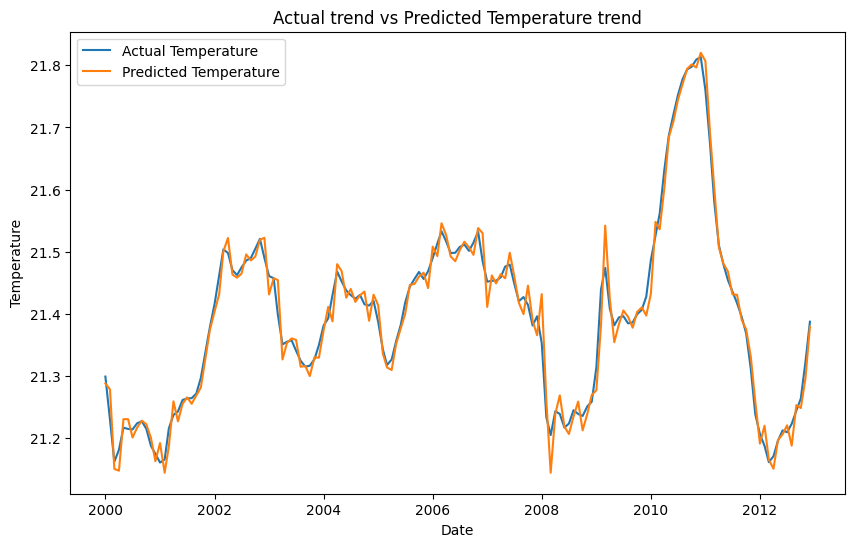

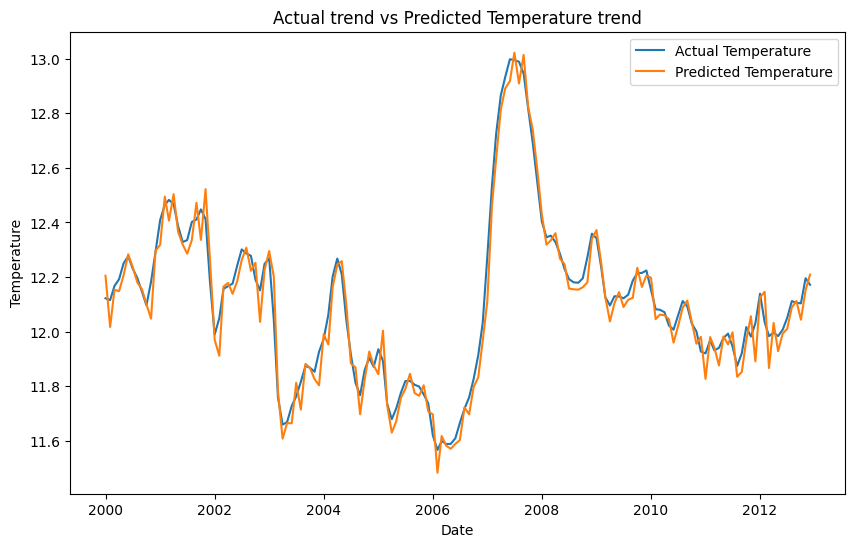

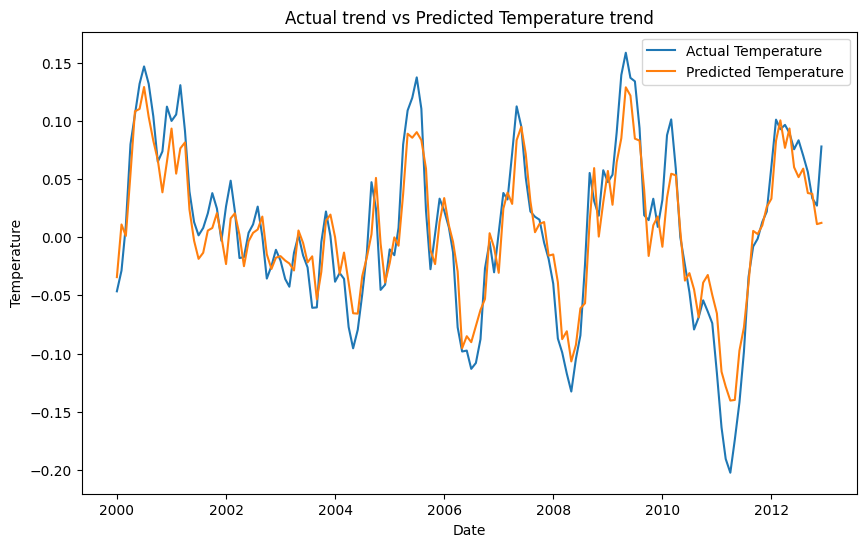

In [40]:
result_df = result_df.loc[(result_df.index >= "2000-01-01") & (result_df.index <= "2012-12-01")]
unique_clusters = result_df['Cluster'].unique()

# Plotting for each cluster
for cluster in unique_clusters:
    cluster_data = result_df[result_df['Cluster'] == cluster]
    
    # Create a line plot for 'AverageTemperature' and 'Predicted_Values'
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=cluster_data.index, y=cluster_data['AverageTemperature'], label='Actual Temperature')
    sns.lineplot(x=cluster_data.index, y=cluster_data['Predicted_Values'], label='Predicted Temperature')
    
    # Set titles and labels
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'Actual trend vs Predicted Temperature trend') #Cluster {cluster}
    plt.legend()
    
    # Show the plot
    plt.show()

In [43]:
# result_df2 = pd.DataFrame()

# # Initialize counters for stationary and non-stationary countries
# stationary_count_first_round = 0
# non_stationary_count_first_round = 0

# stationary_count_second_round = 0
# non_stationary_count_second_round = 0
# # Define the range of p and q values to search
# max_p = 10
# max_q = 10

# for i, j in df_clusters2:
#     # Extract the last rows with similar shape
#     data = j.copy()
#     #data = data.tail(least_rows)
    
#     # # Perform seasonal decomposition
#     # result = seasonal_decompose(data.AverageTemperature, model='additive', period=1)
    
#     # # Get the trend component and drop NaN values
#     # trend_components = result.trend.dropna()
    
#     # # Ensure the indices match
#     # trend_components.index = data.index[-len(trend_components):]
    
#     # # Add the 'Trend' column to the data DataFrame
#     # data["Trend"] = trend_components
    
#     # Concatenate the current data DataFrame with the result DataFrame
#     data = data.dropna()
#     data_to_use = data["AverageTemperature"]
#     data_to_use = pd.DataFrame(data_to_use)
#     #data_to_use.rename(columns={"Trend": "AverageTemperature"}, inplace=True)
    
#     # Check for stationarity using ADF test
#     adf = adf_check(data_to_use["AverageTemperature"], "AIC")
    
    
#     # Check if p-value is less than 0.5
#     if adf[1] <= 0.05:
#         stationary_count_first_round += 1
#         # Time series is stationary
#         # Find the best (p, q) orders using the best_model_arma function
#         best_mse, best_rmse = best_model_arma(data_to_use, max_p, max_q)
#         # Run ARMA with the best (p, q) orders
#         results = ARMA(data_to_use, best_rmse[0], best_rmse[1])
        
#         if results is not None:
#             a = results[0]
#             a["Cluster"] = j["Cluster"]
#             # a["Country_ISO"] = j["Country_ISO"]
#             result_df2 = pd.concat([result_df2, a])
#     else:
#         non_stationary_count_first_round += 1
#         #Time series is non-stationary
#         # Perform necessary steps to make it stationary and then run ARMA
#         original_data = data_to_use.copy()
#         data_to_use["AverageTemperature"] = data_to_use["AverageTemperature"].diff().diff(1).dropna()
        
#         data_to_use = data_to_use.dropna()
        
#         adf = adf_check(data_to_use["AverageTemperature"], "AIC")
    
#         # Check if p-value is less than 0.5
#         if adf[1] <= 0.05:
#             stationary_count_second_round += 1
#             # Time series is stationary
#             # Find the best (p, q) orders using the best_model_arma function
#             best_mse, best_rmse = best_model_arma(data_to_use, max_p, max_q)
#             # Run ARMA with the best (p, q) orders
#             results = ARMA(data_to_use, best_rmse[0], best_rmse[1])
        
#             if results is not None:
#                 a = results[0]
#                 #print(a)
#                 a.AverageTemperature += a.shift(1).AverageTemperature
#                 a.AverageTemperature += a.diff().shift(1).AverageTemperature
#                 a.Predicted_Values += a.shift(1).Predicted_Values 
#                 a.Predicted_Values += a.diff().shift(1).Predicted_Values
#                 a["Cluster"] = j["Cluster"]
#                 # a["Country_ISO"] = j["Country_ISO"]
#                 result_df2 = pd.concat([result_df2, a])
#         else:
#             non_stationary_count_second_round += 1

In [42]:
# result_df2.head(30)

In [41]:
# result_df2 = result_df2.loc[(result_df2.index >= 1950) & (result_df2.index <= 2012)]
# unique_clusters = result_df2['Cluster'].unique()

# # Plotting for each cluster
# for cluster in unique_clusters:
#     cluster_data = result_df2[result_df2['Cluster'] == cluster]
    
#     # Create a line plot for 'AverageTemperature' and 'Predicted_Values'
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(x=cluster_data.index, y=cluster_data['AverageTemperature'], label='Actual Temperature')
#     sns.lineplot(x=cluster_data.index, y=cluster_data['Predicted_Values'], label='Predicted Temperature')
    
#     # Set titles and labels
#     plt.xlabel('Date')
#     plt.ylabel('Temperature')
#     plt.title(f'Actual vs Predicted Temperature - Cluster {cluster}')
#     plt.legend()
    
#     # Show the plot
#     plt.show()